# Sampling with the help of a generative model

Marylou Gabrié, École Polytechnique, CMAP

In this tutorial we will go a simple of example of how we can leverage generative models to assist the computation of expectations via Monte Carlo. Three modules are coming with this notebook to ease implementation:
- `models.py`
- `utils_plot.py`
- `utils_mcmc.py`

In you cloned the repository locally, you should have no issue loading these modules with the `import` commands as done below. On Google Colab however you will need to run the following cell before running the one following. 

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
# sys.path.append('/content/drive/MyDrive/tutorial-sampling-enhanced-w-generative-models')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from models import NormalizingFlow, MoG
from utils_plot import plot_density, grab

## 1 - A mixture of two Gaussians in 2d as a simple toy-target 

Generically speaking, a mixture of Gaussian is a density defined as a weighted sum of Gaussian densities. For Gaussian mixtture with $k$-components in $d$-dimension has density at $x\in \mathbb{R}^d$:

$
\displaystyle \rho(x) = \sum_{i=1}^k \frac{\alpha_i}{\sqrt{(2 \pi)^{d} |\Sigma|}} \; \exp\left[-\frac{1}{2} (x-\mu_i)^T \Sigma_i (x - \mu_i)\right],
$

where $\mu_i \in \R^d$ and $\Sigma_i \in \R^{d\times d}$ are respectivally the mean and covariance of component $i$ and the weights $\alpha_i \in [0,1]$ sum to 1. Here we can simply start with a 2d target distribution with 2 Gaussian components with covariances identity and imbalance weights: 

$
\displaystyle \rho_*(x) = \frac{\alpha_1}{2 \sqrt{2 \pi}} \; \exp\left[-\frac{1}{2} \Vert x - \mu_1 \Vert^2 \right] + \frac{\alpha_2}{2 \sqrt{2 \pi}} \; \exp\left[-\frac{1}{2} \Vert x - \mu_2 \Vert^2\right],
$
with say $\alpha_1 = 0.25$ and $\alpha_2 = 0.75$.

A class `MoG` is defined in the module `models.py` to handle mixture of Gaussians. Let's instantiate the target and plot its density using a function from the module `utils_plot.py`.

/Users/marylou/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


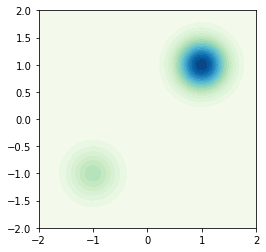

In [3]:
pos = 1 # position of Gaussian components
scale = 0.1 # scale of Gaussian components
covars = [torch.eye(2) * scale, torch.eye(2) * scale]
means = [torch.tensor([-pos, - pos]), torch.tensor([pos, pos])]
target = MoG(means, covars, weights=[0.25, 0.75])

# plot the target 
lims = {'x_min': 2 * - pos, 'x_max': 2 * pos, 'y_min': - 2 * pos, 'y_max': 2 * pos}
plot_density(target.log_prob, lims=lims)

# 2 - A Normalizing Flow

Normalizing flows form a class of generative models that can be used to approximate a target distribution. Again, a ready-made class of flows is provided in the module `models.py`. The class provides a method `log_prob` to compute the log-probability of a batch of samples and a method `sample` to draw samples from the flow. 

The flow defines a parametrized density $\rho_\theta$ trough the transformation of an isotropic Gaussian distribution through a parametrized map which we denote by $T_\theta: \mathbb{R}^d \to \mathbb{R}^d$. This map is invertible: $T_\theta(T^{-1}_\theta(x)) = T^{-1}_\theta(T_\theta(x)) = x$. 

Let's instantiate a simple flow with 2 blocks of 2 Affine Coupling layers. 

In [4]:
dim = 2
n_blocks = 2

model = NormalizingFlow(dim, n_blocks)

- Check that the flow is invertible using the `model.forward` and `model.backward` methods.

- How can you check that the flow is initialized with a $T_\theta$ that is the identity map?

tensor([[ 1.5240,  0.5971],
        [ 0.2188, -1.1273],
        [ 0.4732, -0.8964],
        [ 0.2591, -0.3817],
        [ 1.2265,  0.8804]])
tensor([[ 1.5240,  0.5971],
        [ 0.2188, -1.1273],
        [ 0.4732, -0.8964],
        [ 0.2591, -0.3817],
        [ 1.2265,  0.8804]], grad_fn=<MulBackward0>)
tensor([[ 1.5240,  0.5971],
        [ 0.2188, -1.1273],
        [ 0.4732, -0.8964],
        [ 0.2591, -0.3817],
        [ 1.2265,  0.8804]], grad_fn=<SubBackward0>)


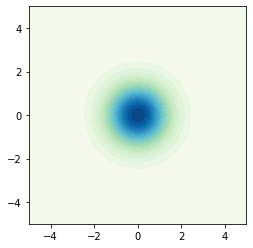

In [5]:
x = torch.randn(5, dim)
y= model.forward(x)
x_prime = model.backward(y)

print(x)
print(y)
print(x_prime)

plot_density(model.log_prob)

## 3 - Training the flow to approximate the target

We can plot the superposition of the target and the flow density as initialized.

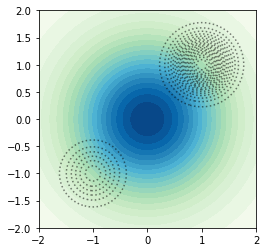

In [6]:
plot_density(model.log_prob, target.log_prob, lims=lims)

Now our goal is to train the flow to approximate the target. We first need a loss function. The Kullback-Leibler divergence between the flow and the target is a good candidate:

$
{\rm KL}(\rho_\theta || \rho_*) =  \int  \rho_\theta(x)  \log \left(\frac{\rho_\theta(x)}{\rho_*(x)} \right) dx.
$

Recall that the $\rm KL$ is always positive and zero if only if $\rho_\theta = \rho_*$. We cannot compute it exactly but we can approximate it using Monte Carlo and samples from the flow: our loss function is then

$
\mathcal{L}(\theta) = \frac{1}{B} \sum_{k=1}^B \left[ \log \left(\frac{\rho_\theta(x^k)}{\rho_*(x^k)} \right) \right]
$

where $x^k$ are samples from the flow and $B$ is the batch size. 
- Implement the loss function in the cell below.

In [7]:

def kl_divergence(model, target, batch_size=100):
    x = model.sample(batch_size)
    return (model.log_prob(x) - target.log_prob(x)).mean()

Below we wrote a function with a simple training loop. Check that everything makes sense. 

In [8]:
def train(model, n_epochs=100, lr=1e-3, batch_size=100):
    plt.figure(figsize=(20, 8))
    axs = [plt.subplot(2, 5, i) for i in range(1, 11)]
    models = []
    losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = kl_divergence(model, target, batch_size=batch_size)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
       
        if epoch % (n_epochs/10) == 0:
            print(f'Epoch {epoch}: {loss.item()}')
            ax_index = int(epoch // (n_epochs/10))
            plot_density(model.log_prob, target.log_prob, lims=lims, 
                         ax=axs[ax_index], title=f'Epoch {epoch}')
    return losses
                    

Let's run the training now:

Epoch 0: 6.210127353668213
Epoch 5: 5.53225040435791
Epoch 10: 4.1186747550964355
Epoch 15: 2.9668281078338623
Epoch 20: 2.376924991607666
Epoch 25: 1.8979300260543823
Epoch 30: 1.2256360054016113
Epoch 35: 1.0809967517852783
Epoch 40: 1.1089911460876465
Epoch 45: 1.1838449239730835


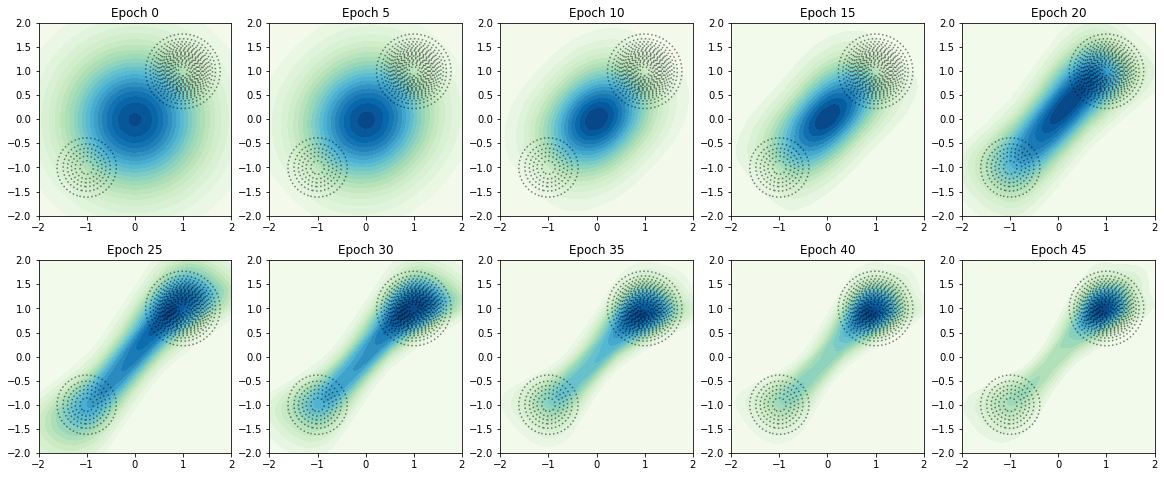

In [9]:
torch.manual_seed(10)  #fix seed for reproducibility/comment to compare different runs
dim = 2
n_blocks = 2
model = NormalizingFlow(dim, n_blocks)

losses = train(model, n_epochs=50, lr=5e-3) 
# increase to 500 iterations to get better results 

- Plot the losses during training to make sure that everything is going well. What would be the ideal value of the loss at the end of training?

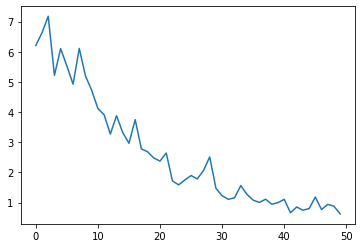

In [10]:
plt.plot(losses)

- Plot the superposition of the samples from the flow and the target density. What do you observe?

(-2.0, 2.0)

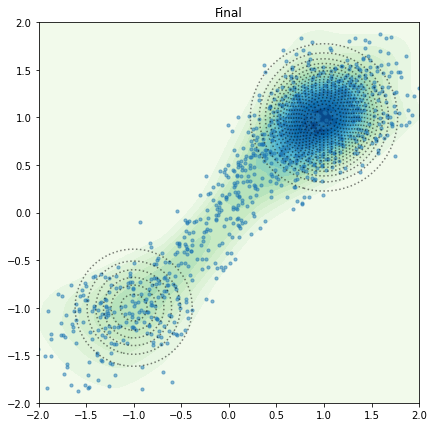

In [11]:
plt.figure(figsize=(7, 7))
xs = model.sample(1000)
plot_density(model.log_prob, target.log_prob, lims=lims, title='Final', ax=plt.gca())
plt.scatter(grab(xs[:, 0]), grab(xs[:, 1]), s=10, alpha=0.5)
plt.gca().set_xlim(lims['x_min'], lims['x_max'])
plt.gca().set_ylim(lims['y_min'], lims['y_max'])


## 4 -  Importance sampling with a trained flow as proposal

Although the flow is not perfect at approximating the target, it can still be of great help to compute expectations. Here we will demonstrate how we can use the flow to compute expectations via importance sampling.

The importance sampling algorithm follows the following logic:
- Draw samples from a proposal distribution easy to sample and for which you can write the density( here we can use the flow): $\quad x_i \sim \rho_\theta(x), \quad$ for $i = 1, \ldots, N$.

- Compute the importance weights: $\quad \omega_i = \frac{\rho_*(x_i)}{\rho_\theta(x_i)}, \quad$ for $i = 1, \ldots, N$.

- Approximate thermodynamic averages of any observable $\mathcal{O}(\cdot)$ under $\rho_*(\cdot)$ as: $\quad \displaystyle \langle \mathcal{O}(x) \rangle_* \approx \sum_{i = 1}^N \frac{w_i \mathcal{O}(x_i)}{\sum_{j=1}^N w_j}  $.


Below we visualize the importance weights for the samples drawn from the flow. The size of the black dots is proportional to the importance weight. Check that it fits your intuition.

(-2.0, 2.0)

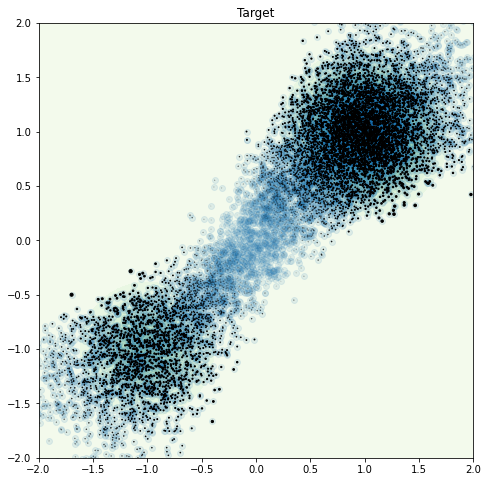

In [12]:
xs = model.sample(10000)
log_ws = target.log_prob(xs) - model.log_prob(xs)  

plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
plot_density(target.log_prob, lims=lims, ax=ax, title='Target')
plt.scatter(grab(xs[:, 0]), grab(xs[:, 1]), alpha=0.1) 
plt.scatter(grab(xs[:, 0]), grab(xs[:, 1]), s=grab(torch.exp(log_ws)), c='k')
plt.gca().set_xlim(lims['x_min'], lims['x_max'])
plt.gca().set_ylim(lims['y_min'], lims['y_max'])


To normalize the weights, we should use the numerically stable [`logsumexp`](https://pytorch.org/docs/stable/generated/torch.logsumexp.html),  (click to check the documentation).

In [13]:
log_normalized_ws = log_ws - torch.logsumexp(log_ws, dim=0)
normalized_ws = torch.exp(log_normalized_ws)

By summing the corresponding weights, we can compute the weight of each Gaussian component. For example, we can compute the weight of the first Gaussian component by filtering the weighted samples in the positive quadrant of the plane. Check that the result makes sense.

In [14]:
weight_mode_pos = normalized_ws[(xs[:, 0] > 0) * (xs[:, 1] > 0)].sum()
print('We predict a weight for the mode in the positive cadrant of:', weight_mode_pos.item())

We predict a weight for the mode in the positive cadrant of: 0.7476774454116821


- For this simple 2d problem, check that we could have obtained a similar result by using a simpler proposal distribution than the trained normalizing flow (e.g. uniform or isotropic Gaussian).
- Do you have an intuition of when these simple strategies break?

We predict a weight for the mode in the positive cadrant of: 0.7294996380805969


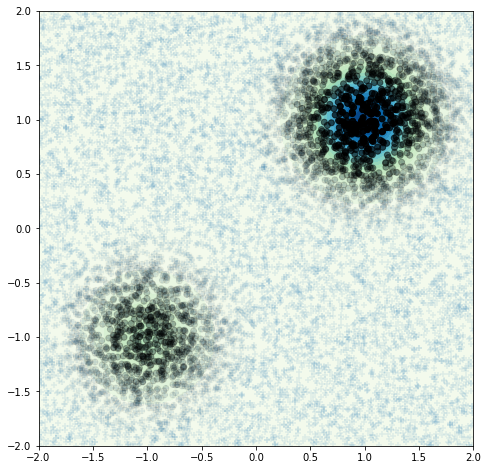

In [15]:
xs = (torch.rand(10000, 2) * 2 - 1) * 2
log_ws = target.log_prob(xs) 

log_normalized_ws = log_ws - torch.logsumexp(log_ws, dim=0)
normalized_ws = torch.exp(log_normalized_ws)


plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
plot_density(target.log_prob, lims=lims, ax=ax)
plt.scatter(grab(xs[:, 0]), grab(xs[:, 1]), marker='+', alpha=0.1) 
plt.scatter(grab(xs[:, 0]), grab(xs[:, 1]), alpha=(normalized_ws / normalized_ws.max())
, c='k')
# plt.gca().set_xlim(lims['x_min'], lims['x_max'])
# plt.gca().set_ylim(lims['y_min'], lims['y_max'])

weight_mode_pos = normalized_ws[(xs[:, 0] > 0) * (xs[:, 1] > 0)].sum()
print('We predict a weight for the mode in the positive cadrant of:', weight_mode_pos.item())

## 5- Markov Chain Monte Carlo with a trained flow as proposal

We can also leverage the flow as a proposal distribution in a Metropolis-Hastings MCMC. The algorithm is as follows:
- Intialize $x^{(0)}$ at random.
- For $t = 1, \ldots, T$:
    - Draw a candidate sample $x^{(t)}$ from the flow: $\quad x^{(t)} \sim \rho_\theta(x)$.
    - Accept the candidate with probability:  $\quad \min\left[1, \frac{\rho_*(x^{(t)}) \rho_\theta(x^{(t-1)})}{\rho_*(x^{(t-1)})\rho_\theta(x^{(t)})} \right]$.
    - If rejected, set:  $\quad x^{(t)} = x^{(t-1)}$.

The Markov Chain $(x^{(t)})_{t=1}^T$ (once converged) provides a sample from the target distribution $\rho_*(\cdot)$.

- Implement the MCMC algorithm described above. As an example, we provide a function implementing the Metropolis Adjusted Langevin Algorithm (MALA) in the module `utils_mcmc.py`. You can use it as a reference. We also provide a visualization of the samples from the MALA MCMC.

Mean acceptance rate: 0.8759999871253967


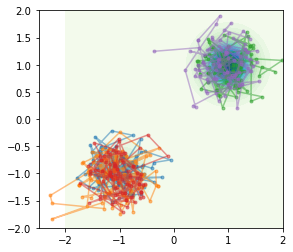

In [16]:
from utils_mcmc import run_mala, get_grad_U

torch.manual_seed(10)  #fix seed for reproducibility/comment to compare different runs

U = lambda x: - target.log_prob(x)
grad_U = get_grad_U(U)

n_samples = 5
x_init = torch.randn(n_samples, 2)

xs, accs = run_mala(U, grad_U, x_init, n_steps=100, dt=0.05)

plot_density(target.log_prob, lims=lims)
plt.plot(grab(xs[:, :, 0]), grab(xs[:, :, 1]), '.-', alpha=0.5)

print('Mean acceptance rate:', (accs * 1.).mean().item())

100%|██████████| 100/100 [00:01<00:00, 74.71it/s]


Mean acceptance rate: 0.34200000762939453


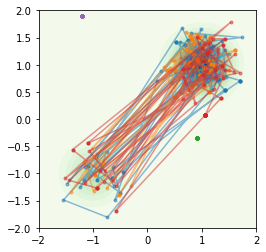

In [17]:
from utils_mcmc import accept_filter
import tqdm

def run_metropolis(model_sample, model_nll, target_U, x_init, n_steps, with_tqdm=False):
    xs = []
    accs = []
    ms = []

    range_ = tqdm.tqdm(range(n_steps)) if with_tqdm else range(n_steps)

    for dt in range_:
        x = model_sample(x_init.shape[0])
        log_ratio = -target_U(x) + model_nll(x)
        log_ratio += target_U(x_init) - model_nll(x_init)
        log_ratio = log_ratio

        x, acc = accept_filter(log_ratio, x, x_init)

        xs.append(x.clone())
        accs.append(acc)
        x_init = x.clone()

    return torch.stack(xs), torch.stack(accs)

model_nll = lambda x: - model.log_prob(x)
target_U = lambda x: - target.log_prob(x)
xs, accs = run_metropolis(model.sample, model_nll, target_U, x_init, n_steps=100, with_tqdm=True)

plot_density(target.log_prob, lims=lims)
plt.plot(grab(xs[:, :, 0]), grab(xs[:, :, 1]), '.-', alpha=0.5)

print('Mean acceptance rate:', (accs * 1.).mean().item())


References: 
- [1] Albergo et al. "Flow-based generative models for Markov chain Monte Carlo in lattice field theory" (2019) (https://arxiv.org/abs/1904.12072)
- [2] Gabrié et al. "Adaptive Monte Carlo augmented with normalizing flows" (2021) (https://arxiv.org/abs/2105.12603)
and references therein!